<a href="https://www.kaggle.com/code/testanother/classification-on-imbalanced-data?scriptVersionId=117019600" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# https://www.buckys5thquarter.com/2019/5/28/18237355/wisconsin-football-punting-paul-chryst-anthony-lotti-chart-party
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nfl-big-data-bowl-2022/players.csv
/kaggle/input/nfl-big-data-bowl-2022/PFFScoutingData.csv
/kaggle/input/nfl-big-data-bowl-2022/tracking2019.csv
/kaggle/input/nfl-big-data-bowl-2022/tracking2020.csv
/kaggle/input/nfl-big-data-bowl-2022/games.csv
/kaggle/input/nfl-big-data-bowl-2022/tracking2018.csv
/kaggle/input/nfl-big-data-bowl-2022/plays.csv


In [2]:
df_players = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2022/players.csv')
df_games = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2022/games.csv')
df_plays = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2022/plays.csv')
df_scouting = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2022/PFFScoutingData.csv')

In [3]:
df_field_goal = df_plays[df_plays['specialTeamsPlayType'] == 'Field Goal']
df_field_goal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2657 entries, 2 to 19965
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gameId                  2657 non-null   int64  
 1   playId                  2657 non-null   int64  
 2   playDescription         2657 non-null   object 
 3   quarter                 2657 non-null   int64  
 4   down                    2657 non-null   int64  
 5   yardsToGo               2657 non-null   int64  
 6   possessionTeam          2657 non-null   object 
 7   specialTeamsPlayType    2657 non-null   object 
 8   specialTeamsResult      2657 non-null   object 
 9   kickerId                2643 non-null   float64
 10  returnerId              2 non-null      object 
 11  kickBlockerId           37 non-null     float64
 12  yardlineSide            2657 non-null   object 
 13  yardlineNumber          2657 non-null   int64  
 14  gameClock               2657 non-null  

In [4]:
cols = ['yardsToGo', 'yardlineNumber', 'kickLength', 'playResult', 'specialTeamsResult']
df = df_field_goal[cols]
df

,yardsToGo,yardlineNumber,kickLength,playResult,specialTeamsResult
2,3,3,21.0,0,Kick Attempt Good
6,8,8,26.0,0,Kick Attempt Good
8,17,34,52.0,0,Kick Attempt Good
33,13,23,41.0,0,Kick Attempt Good
36,9,34,52.0,-8,Kick Attempt No Good
...,...,...,...,...,...
19952,10,17,36.0,0,Kick Attempt Good
19955,3,12,30.0,0,Kick Attempt Good
19959,6,18,36.0,0,Kick Attempt Good
19962,8,29,47.0,0,Kick Attempt Good


In [5]:
df.isnull().sum()

yardsToGo              0
yardlineNumber         0
kickLength            51
playResult             0
specialTeamsResult     0
dtype: int64

In [6]:
x = df.dropna()
x['specialTeamsResult'] = x['specialTeamsResult'].apply(lambda x: 1 if str(x) in 'Kick Attempt Good' else 0)
x

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,yardsToGo,yardlineNumber,kickLength,playResult,specialTeamsResult
2,3,3,21.0,0,1
6,8,8,26.0,0,1
8,17,34,52.0,0,1
33,13,23,41.0,0,1
36,9,34,52.0,-8,0
...,...,...,...,...,...
19952,10,17,36.0,0,1
19955,3,12,30.0,0,1
19959,6,18,36.0,0,1
19962,8,29,47.0,0,1


<AxesSubplot:xlabel='specialTeamsResult', ylabel='count'>

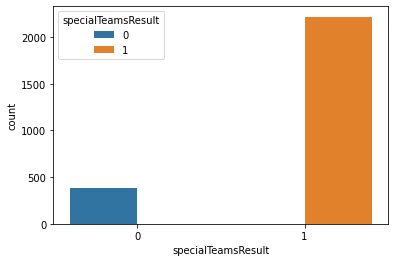

In [7]:
import seaborn as sns 
sns.countplot(data=x, x="specialTeamsResult", hue='specialTeamsResult')

In [8]:
from sklearn.model_selection import train_test_split
y = x['specialTeamsResult']
X_train, X_test, y_train, y_test = train_test_split(x.drop(columns=['specialTeamsResult'], axis=1), y, test_size=0.3)

In [9]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [10]:
ada_clf = AdaBoostClassifier()
knn_clf = KNeighborsClassifier()
svc_clf = SVC(kernel="linear", class_weight='balanced')
xgbc_clf = XGBClassifier(scale_pos_weight=5)
rnd_frst = RandomForestClassifier(n_estimators=100, class_weight="balanced")

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

classifiers = [ada_clf, knn_clf, svc_clf, rnd_frst, xgbc_clf]

def run_classifier_models(cls_models, X_train, y_train, X_test, y_test):
    for clsfr in cls_models:
        clf = make_pipeline(StandardScaler(), clsfr)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        print('score for ', clsfr.__class__.__name__, score)
        if "SVC" not in clsfr.__class__.__name__:
            print('roc auc score', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
        print(
            f"Classification report for classifier {clf}:\n"
            f"{classification_report(y_test, clf.predict(X_test))}\n"
        )
        
run_classifier_models(classifiers, X_train, y_train, X_test, y_test)

score for  AdaBoostClassifier 1.0
roc auc score 1.0
Classification report for classifier Pipeline(steps=[('standardscaler', StandardScaler()),
                ('adaboostclassifier', AdaBoostClassifier())]):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       119
           1       1.00      1.00      1.00       663

    accuracy                           1.00       782
   macro avg       1.00      1.00      1.00       782
weighted avg       1.00      1.00      1.00       782


score for  KNeighborsClassifier 1.0
roc auc score 1.0
Classification report for classifier Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())]):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       119
           1       1.00      1.00      1.00       663

    accuracy                           1.00       782
   macro avg       1.00      1.00 

In [12]:
# Try to upsample
from sklearn.utils import resample

df_majority = x[x.specialTeamsResult==1]
df_minority = x[x.specialTeamsResult==0]

num_samples = 2218

df_minority_upsampled = resample(df_minority, replace=True, n_samples=num_samples)

df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
df_upsampled.specialTeamsResult.value_counts()

1    2218
0    2218
Name: specialTeamsResult, dtype: int64

<AxesSubplot:xlabel='specialTeamsResult', ylabel='count'>

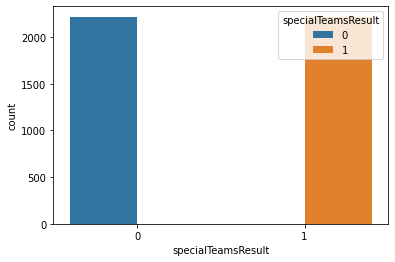

In [13]:
sns.countplot(data=df_upsampled, x="specialTeamsResult", hue='specialTeamsResult')

In [14]:
X_scaled_train, X_scaled_test, y_scaled_train, y_scaled_test = train_test_split(df_upsampled.drop(columns=['specialTeamsResult'], axis=1), df_upsampled['specialTeamsResult'], test_size=0.3)

In [15]:
run_classifier_models(classifiers, X_scaled_train, y_scaled_train, X_scaled_test, y_scaled_test)

score for  AdaBoostClassifier 1.0
roc auc score 1.0
Classification report for classifier Pipeline(steps=[('standardscaler', StandardScaler()),
                ('adaboostclassifier', AdaBoostClassifier())]):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       695
           1       1.00      1.00      1.00       636

    accuracy                           1.00      1331
   macro avg       1.00      1.00      1.00      1331
weighted avg       1.00      1.00      1.00      1331


score for  KNeighborsClassifier 0.9977460555972952
roc auc score 1.0
Classification report for classifier Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())]):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       695
           1       1.00      1.00      1.00       636

    accuracy                           1.00      1331
   macro avg       